# Self-Supervised Monocular Depth Estimation based on Left-Right Consistency Check
### Xiule Fan

## Abstract

Depth estimation is widely used in the fields of robotics and autonomous driving. Traditionally, depth information is acquired by the use of various sensors and technologies, such as infrared sensors, LiDAR and stereo cameras. Generally speaking, these methods are prone to some of the following errors/problems: noise, occlusion, sensitivity to lighting conditions, high cost. These disadvantages and the low cost of single-lense/monocular cameras have motivated researchers to seek alternative solutions using monocular images. Humans can easily sense depth with even only one eye. This is because humans generally have years of experience with size of different objects. Naturally, researchers turn to machine learning to achieve depth estimation with monocular images. There are two major approaches in monocular depth estimation: supervised approaches and self-supervised approaches. The work by Eigen et al. [1] has laid down the foundation for supervised monocular depth estimation. Essentially, they treat the problem as a regression problem and try to match the predicted depth from a single image to its ground truth depth map. Since then, a lot of supervised variations have been proposed, such as the ones based on CRF [2], GAN [3], etc. For these methods to work, a large dataset with dense ground truth depth maps is required. Acquiring such a dataset needs substantial effort and resources.

For self-supervised approaches, researchers have identified mainly two possible options. The first option is based on the work by Zhou et al. [4]. In their paper, they outline a method which uses video sequences as input. The network predicts depth for the frame at time $t$ as well as transformations between frames $t-1$ and $t$ and between frames $t$ and $t+1$. By using the depth information and transformations, these three frames can be warped to the same references. From there, their photemetric loss can be constructed. One major problem they have identified in their paper is that the predicted depth is only unique up to scale. 

A second approach, and also the approach that this project is based on, is outlined in Godard's work [5]. They propose an encoder-decoder architecture which can predict two different disparities $d^r$ and $d^l$ from the left image $I^l$ of a rectified image pair. With the predicted disparities, the algorithm then reconstruct the left view $\tilde{I}^l$ and right view $\tilde{I}^r$ as $\tilde{I}^l = I^r(d^l)$ and $\tilde{I}^r = I^l(d^r)$ where $I^r$ is the original right image in an image pair. Additionally, the reconstructed disparities $\tilde{d}$ can also be achieved for both left and right as $\tilde{d}^l = d^r(d^l)$ and $\tilde{d}^r = d^l(d^r)$. With all this information, the loss is constructed to contain the appearance matching loss between original images $I^r$, $I^l$ and reconstructed images $\tilde{I}^r$, $\tilde{I}^l$, smoothness within the predicted disparities $d^r$, $d^l$, as well as consistency between the predicted $d^r$, $d^l$ and the reconstructed disparities $\tilde{d}^r$, $\tilde{d}^l$. Note that even though image pairs are required during training, only the left image is sent into the neural network while the right image is used as a supervisory signal. During testing, only the left image is used for inference. The detailed design will be discussed below. Note that even though the project is for depth estimation, we only compare disparity here since disparity can be converted to depth easily if the camera focal length and baseline are known.

## Design
### Network Design
The detailed design of the neural network can be seen in ```mylibs/nets.py```. The network follows an encoder-decoder design. The encoder is essentially the pretrained Resnet50 network without the fully connected layer. Assume the input image to the network is of the size $3\times H\times W$, the encoder increases its number of channels and decreases the spatial resolution gradually in the following order
- $64\times H/4 \times W/4$
- $256\times H/4 \times W/4$
- $512\times H/8 \times W/8$
- $1024\times H/16 \times W/16$
- $2056\times H/32 \times W/32$

The encoder tries to extract various levels of features which may be useful for estimating disparities. The decoder starts from the feature of $2056\times H/32 \times W/32$ and increases its spatial resolution by the following order
- $1024\times H/16 \times W/16$
- $512\times H/8 \times W/8$
- $256\times H/4 \times W/4$
- $64\times H/4 \times W/4$
- $4\times H \times W$

The spatial resolution of the output from each decoder layer matches spatial resolution of feature from a corrensponding encoder layer or the original image to allow for skip connection. In addtion to increasing spatial resolution, the model also completes the operation shown below [5] in most of the decoder layer (if the link to the image is broken, check the image in the ```images``` folder). 

<img src="images/decoder_layer.png"/>

Use the decoder layer that converts feature from $2056\times H/32 \times W/32$ to $1024\times H/16 \times W/16$ as an example. When the feature is still at $2056\times H/32 \times W/32$, two separated convolution layers use it to obtain $1\times H/32 \times W/32$ estimated disparities $d^r$ and $d^l$, repectively. With $d^r$, $d^l$ and image pair downsampled to $3\times H/32 \times W/32$ $I^r$ and $I^l$, construct the reconstructed images $\tilde{I}^l = I^r(d^l)$ and $\tilde{I}^r = I^l(d^r)$ through bilinear sampling (``torch.nn.functional.grid_sample``). Additionally, we also reconstruct $\tilde{d}^l = d^r(d^l)$ and $\tilde{d}^r = d^l(d^r)$ by bilinear sampling as well. All of these values will be used for cost calculation which will be described in the next section. Then the $2056\times H/32 \times W/32$ feature expands its spatial resolution by transposed convolution to $1024\times H/16 \times W/16$. The $1024\times H/16 \times W/16$ feature is then concatenated with the encoder output with resolution $1024\times H/16 \times W/16$ as well as both disparity estimates upsampled to $1\times H/16 \times W/16$. After concatenation, the feature is of the size $2050\times H/16 \times W/16$. Lastly, a convolution layer is applied to the concatenated feature so that the output from the decoder layer is still $1024\times H/16 \times W/16$. Note that as per the description in the paper, all of the activation functions are ELU instead of ReLU since the authors claim that ReLU tend to fix estimated disparity at intermediate scales instead of allowing further improvement in downstream process. However, after some testing, the activation functions for layers that produce disparity at different scales are chosen as sigmoid. Since a sigmoid function only produces values between 0 and 1, the outputs are then scaled by 0.3*width of image at that scale to obtain the predicted disparity.

The last decoder layer uses two transposed convolution layers in series to convert the feature from $64\times H/4 \times W/4$ to $4\times H \times W$. Following these two opreations, another convolution layer with sigmoid as activation function and scaling as mentioned above is used to predict disparity at this scale. The $1\times H \times W$ output is used as the final output of the model during testing. 

Detailed implementation including kernel size, stride, padding, etc. can be found in the ```mylibs/nets.py``` file.

### Cost Function
Detailed implementation of the cost function is found in ```mylibs/loss.py```. The cost function consists of 3 parts: appearance matching loss $C_{ap}$, disparity smoothness loss $C_{ds}$, and left-right disparity consistency loss $C_{lr}$ [5]. The same loss function is applied to disparity estimation and image/disparity reconstruction at all 5 decoder layers for both the left and right disparities and images. The total loss is the sum of the cost function at all 5 scales.
$$C=C_1 + C_2 + C_3 + C_4 + C_5$$
For the cost function at scale $i$, it is
$$C_i=\alpha_{ap}(C_{ap}^l+C_{ap}^r)+\alpha_{ds}(C_{ds}^l+C_{ds}^r)+\alpha_{lr}(C_{lr}^l+C_{lr}^r)$$
where all of the $\alpha$'s are weights. In the implementation shown later, $\alpha_{ap}=3$, $\alpha_{lr}=0.75$ and $\alpha_{ds}=0.1\times scale$. The scale here is how much an image has decreased in size at that scale, e.g. $scale=32$ if the cost function is applied to the decoder layer with $1\times H/32 \times H/32$ estimated disparity map. When running on a single image just for testing the code, this chose of weights seems to work sometimes. However, as seen later, training on the whole dataset seems to fail in this project.

By using the left image as an example, the appearance matching cost is
$$C_{ap}^l=\frac{1}{N}\sum_{i,j}\alpha\frac{1-SSIM(I_{ij}^l, \tilde{I}_{ij}^l)}{2}+(1-\alpha)\left|\left|I_{ij}^l- \tilde{I}_{ij}^l\right|\right|$$
where $N$ is the total number of pixels and $\alpha=0.85$ is a constant. $SSIM$ is a measure of similarity between two image windows by analyzing their mean and variance. Here the window size is 7x7. The mean and variance are obtained based on a 7x7 average pooling layer applied to $I_{ij}^l$ and $\tilde{I}_{ij}^l$.

The disparity smoothness loss is defined by
$$C_{ds}^l=\frac{1}{N}\sum_{i,j}\left|\partial_xd_{ij}^l\right|e^{-\left|\left|\partial_xI_{ij}^l\right|\right|}+\left|\partial_yd_{ij}^l\right|e^{-\left|\left|\partial_yI_{ij}^l\right|\right|}$$
Using gradient of the image ensures that the disparity smoothness is not enforced at the edge.

The left-right disparity consistency loss is 
$$C_{lr}^l=\frac{1}{N}\sum_{i,j}\left|d_{ij}^l-\tilde{d}_{ij}^l\right|$$

All of these three costs are also mirrored to the right view at each scale.

## Code Libraries
The following packages are required to run the program. They can all be installed from anaconda:
- numpy: for data manipulation (https://anaconda.org/anaconda/numpy)
- matplotlib: for plotting (https://anaconda.org/conda-forge/matplotlib)
- scikit-image: for opening images (https://anaconda.org/conda-forge/scikit-image)
- pytorch: for building the neural network (https://anaconda.org/pytorch/pytorch)
- torchvision: for data transformation and using pretrained network (https://anaconda.org/pytorch/torchvision)
- opencv: for calculating disparity by stereo matching for comparison with predicted disparity from the network (https://anaconda.org/conda-forge/opencv)

Technically speaking, we can use the functions in opencv to access images. That way, we don't need scikit-image to run the program. However, the ```mylibs/kitti_dataset.py``` was developed in the early phase of this project and the use of opencv wasn't considered yet at that stage, modifying this package is necessary to allow for such a change.

## Custom Libraries
Inside the folder ```mylibs```, the following packages are available:
- ```kitti_dataset.py```: a class to manipulate data from the KITTI dataset so that they can work with dataloader from pytorch
- ```loss.py```: define the loss calculation for training
- ```nets.py```: define the neural network
- ```transforms.py```: define a number of image transformations for data augmentation purposes

## Dataset
In the original paper, the authors train their network with a large KITTI dataset which takes up lots of space (175GB). This is beyond the capacity of my own machine or Google Colab. Therefore, I use a much smaller dataset for training. The dataset I chose is the KITTI stereo evaluation 2015 dataset (http://www.cvlibs.net/datasets/kitti/eval_scene_flow.php?benchmark=stereo). If you haven't doen so, you can run the ``get_dataset.sh`` script to prepare the dataset. If you have already done it, you can skip this section.

In [1]:
# Uncomment the command below if running on local machine
# !./get_dataset.sh

Commands below are for copying data when I run this notebook on my Google Colab

In [2]:
# Comment out the commands below when running on local machine
from google.colab import drive
drive.mount('/content/drive')
!cp "drive/MyDrive/Colab Notebooks/left_right_consistency/mylibs.zip" .
!cp "drive/MyDrive/Colab Notebooks/left_right_consistency/get_dataset.sh" .
!unzip -q mylibs.zip
!chmod +x get_dataset.sh
!./get_dataset.sh

Mounted at /content/drive
--2020-12-18 04:43:08--  https://s3.eu-central-1.amazonaws.com/avg-kitti/data_stereo_flow.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.47.83
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.47.83|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2008641404 (1.9G) [application/zip]
Saving to: ‘data_stereo_flow.zip’

data_stereo_flow.zi 100%[===================>]   1.87G  69.6MB/s    in 27s     

2020-12-18 04:43:35 (72.0 MB/s) - ‘data_stereo_flow.zip’ saved [2008641404/2008641404]



## Implementation
### 1. Import necessray packages

In [3]:
%matplotlib inline

import torch
import cv2 as cv
from mylibs.nets import Net
from mylibs.kitti_dataset import KITTIDataset
from mylibs.transforms import *
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

USE_GPU = True

### 2. Define two high level functions for training and validation

In [4]:
def train(train_loader, net, optimizer, loss_graph):
    main_loss = 0
    if USE_GPU:
        net = net.cuda()
    else:
        net = net.cpu()

    for i, data in enumerate(train_loader):
        left_img, right_img = data
        if USE_GPU:
            left_img = left_img.cuda()
            right_img = right_img.cuda()
        else:
            left_img = left_img.cpu()
            right_img = right_img.cpu()

        optimizer.zero_grad()
        loss = net.forward(left_img, right_img)
        loss.backward()
        optimizer.step()
        main_loss = main_loss + loss
    loss_graph.append(main_loss)
    return main_loss

In [5]:
def validate(val_loader, net):
    val_loss = 0
    output = []
    if USE_GPU:
        net = net.cuda()
    else:
        net = net.cpu()

    with torch.no_grad():
        for i, data in enumerate(val_loader):
            left_img, right_img = data
            if USE_GPU:
                left_img = left_img.cuda()
                right_img = right_img.cuda()
            else:
                left_img = left_img.cpu()
                right_img = right_img.cpu()

            loss, disp_R = net.forward(left_img, right_img)
            val_loss = val_loss + loss
            output.append(disp_R)
    return val_loss, output

### 3. Transformations for Data Augmentation
Transformations include
- Convert all images to torch tensors
- Crop the center (320, 1216) of each image. The size is chosen because the network's input size should be a multiple of 64
- Randomly flip and swap left and right images in a pair
- Normalize images

In [6]:
transforms = [ToTensor(), CenterCrop([320, 1216]), RandomFlip(), NormalizeImg()]

### 4. Prepare Dataset
Use images in the folder called "testing" for both validation and testing. In practice, this should not be done. The reason for doing this is because the whole dataset used here is small. Splitting the training set into two parts for training and validation is not very feasible.

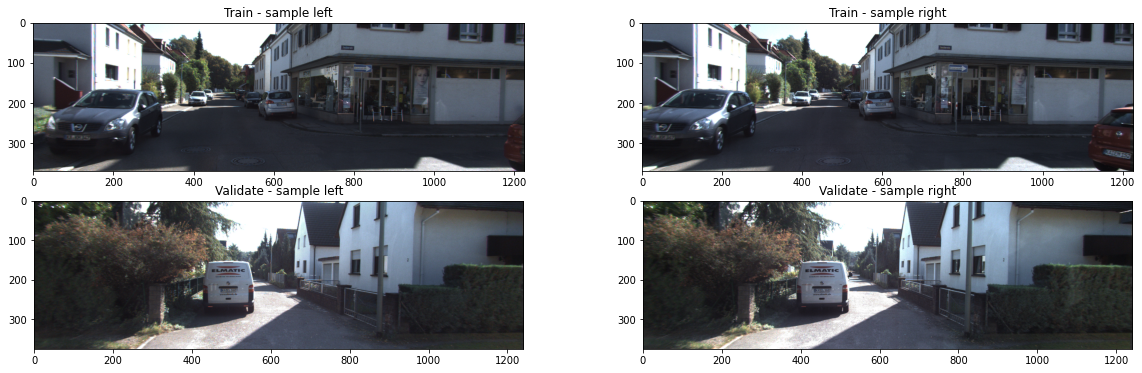

In [7]:
data_path = "dataset"

# the following four lines are for local machine
# uncomment them when running on local machine
#KITTIData_train = KITTIDataset(data_path, 'train', transforms=transforms)
#KITTIData_val = KITTIDataset(data_path, 'validate', transforms=transforms)
#KITTIData_sanity = KITTIDataset(data_path, 'train', transforms=transforms, sanity_check=20)
#KITTIData_val_sanity = KITTIDataset(data_path, 'validate', transforms=transforms, sanity_check=10)

# the following five lines are for Google Colab
# comment them out when working on local machine
data_path_override = '/content/dataset'
KITTIData_train = KITTIDataset(data_path, 'train', transforms=transforms, data_path_override = data_path_override)
KITTIData_val = KITTIDataset(data_path, 'validate', transforms=transforms, data_path_override = data_path_override)
KITTIData_sanity = KITTIDataset(data_path, 'train', transforms=transforms, sanity_check=20, data_path_override = data_path_override)
KITTIData_val_sanity = KITTIDataset(data_path, 'validate', transforms=transforms, sanity_check=10, data_path_override = data_path_override)

train_loader = DataLoader(KITTIData_train, batch_size=4, shuffle=False)
validate_loader = DataLoader(KITTIData_val, batch_size=1, shuffle=False)
sanity_loader = DataLoader(KITTIData_sanity, batch_size=1, shuffle=False)

# get examples from training dataset as well as the closest disparity of these example
left_img, right_img = KITTIData_sanity.get_original_img_pair(0)
disp = KITTIData_sanity.get_disp(0)

# get examples from validation set. No disparity is available in the validation folder
left_img_val, right_img_val = KITTIData_val_sanity.get_original_img_pair(0)

fig = plt.figure(figsize=(20,6))
ax1 = fig.add_subplot(2,2,1)
plt.title('Train - sample left')
ax1.imshow(left_img)
ax2 = fig.add_subplot(2,2,2)
plt.title('Train - sample right')
ax2.imshow(right_img)
ax3 = fig.add_subplot(2,2,3)
plt.title('Validate - sample left')
ax3.imshow(left_img_val)
ax4 = fig.add_subplot(2,2,4)
plt.title('Validate - sample right')
ax4.imshow(right_img_val)

### 5. Define Network and Optimizer for Training
Use Adam optimizer here with parameters $\beta_1=0.9$,  $\beta_2=0.999$, learning rate = $10^{-7}$

In [8]:
EPOCH = 200
DepthNet = Net(USE_GPU)
DepthNet.train()
optimizer = torch.optim.Adam(DepthNet.parameters(), lr=0.0000001, betas=[0.9, 0.999])
loss_graph = []

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


### 6. Training

Start training...


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Epoch: 0 Loss: 11553.8134765625
Epoch: 10 Loss: 8990.572265625
Epoch: 20 Loss: 8009.2080078125
Epoch: 30 Loss: 7661.51171875
Epoch: 40 Loss: 7503.2314453125
Epoch: 50 Loss: 7371.533203125
Epoch: 60 Loss: 7257.73046875
Epoch: 70 Loss: 7162.13623046875
Epoch: 80 Loss: 7082.3203125
Epoch: 90 Loss: 7015.32275390625
Epoch: 100 Loss: 6953.908203125
Epoch: 110 Loss: 6904.236328125
Epoch: 120 Loss: 6859.2255859375
Epoch: 130 Loss: 6817.9228515625
Epoch: 140 Loss: 6782.09423828125
Epoch: 150 Loss: 6747.2607421875
Epoch: 160 Loss: 6714.19970703125
Epoch: 170 Loss: 6681.31787109375
Epoch: 180 Loss: 6647.24169921875
Epoch: 190 Loss: 6616.740234375


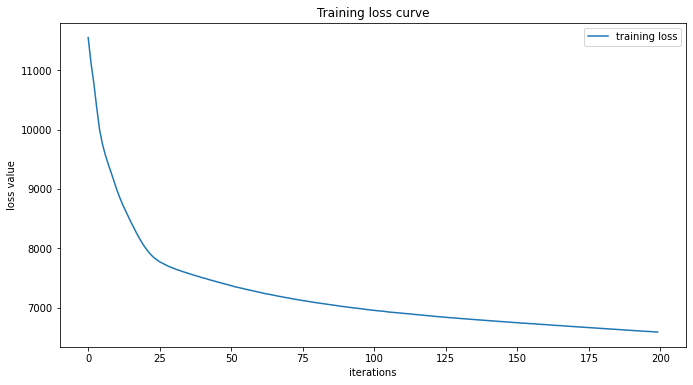

CPU times: user 3h 54min 9s, sys: 34min 56s, total: 4h 29min 5s
Wall time: 3h 26min 28s


In [9]:
%%time

print('Start training...')

fig = plt.figure(figsize=(12, 6))
plt.subplots_adjust(bottom=0.2, right=0.85, top=0.95)
ax = fig.add_subplot(1, 1, 1)

for e in range(EPOCH):
    loss = train(train_loader, DepthNet, optimizer, loss_graph)
    ax.clear()
    ax.set_xlabel('iterations')
    ax.set_ylabel('loss value')
    ax.set_title('Training loss curve')
    ax.plot(loss_graph, label='training loss')
    ax.legend(loc='upper right')
    fig.canvas.draw()
    if e % 10 == 0:
      print("Epoch: {} Loss: {}".format(e, loss))

plt.show()   

# save model
model_path = 'trained_model.pt'
torch.save(DepthNet, model_path)

### 7. Validate over the validation set

In [10]:
%%time
DepthNet.eval()
print('Start validation....')
val_loss, _ = validate(validate_loader, DepthNet)
print('Validation loss is: %f' % val_loss.cpu().numpy())

Start validation....


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Validation loss is: 26703.046875
CPU times: user 1min 12s, sys: 3.43 s, total: 1min 16s
Wall time: 57.2 s


### 8. Inference on training set example

In [11]:
# define an object for stereo matching
stereo_construct = cv.StereoBM_create(numDisparities=400, blockSize=15)

Loss of a sample from training set is: 61.970741


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


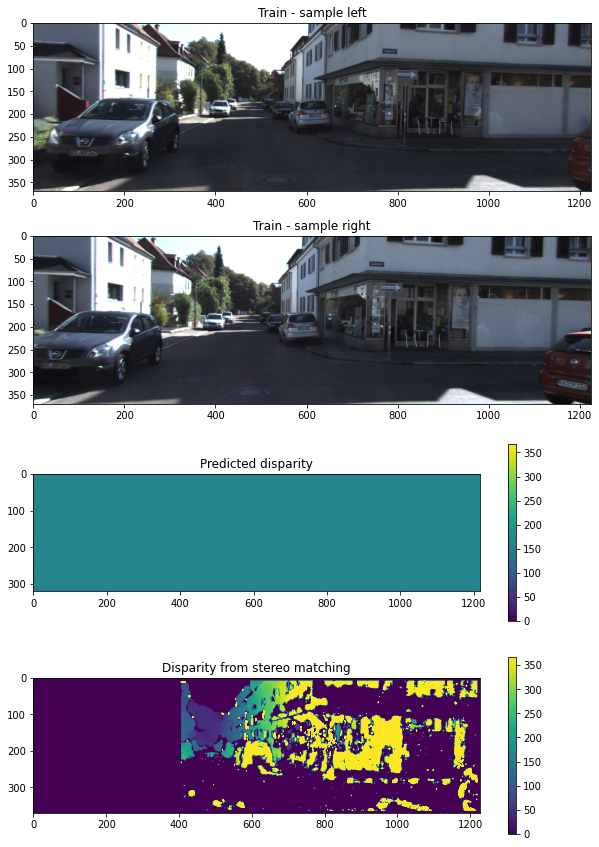

In [12]:
train_L, train_R = ToTensor()(left_img, right_img)
train_L, train_R = CenterCrop([320, 1216])(train_L, train_R)
train_L, train_R = NormalizeImg()(train_L, train_R)

if USE_GPU:
    train_L = train_L.cuda()
    train_R = train_R.cuda()

# calculate disparity from stereo matching
# the opencv algorithms use grayscale images as input
left_img_gray = cv.cvtColor(left_img, cv.COLOR_BGR2GRAY)
right_img_gray = cv.cvtColor(right_img, cv.COLOR_BGR2GRAY)
img_disp = stereo_construct.compute(left_img_gray, right_img_gray)

# note that although an img pair is passed into the model, disparity is calculated by train_L only. train_R is
# used for loss calculation
DepthNet.eval()
train_sample_loss, train_sample_disp = DepthNet.forward(train_L[None], train_R[None])
print('Loss of a sample from training set is: %f' % train_sample_loss)
fig = plt.figure(figsize=(10,15))
ax1 = fig.add_subplot(4,1,1)
plt.title('Train - sample left')
ax1.imshow(left_img)
ax2 = fig.add_subplot(4,1,2)
plt.title('Train - sample right')
ax2.imshow(right_img)
ax3 = fig.add_subplot(4,1,3)
plt.title('Predicted disparity')
im=ax3.imshow(train_sample_disp.cpu().detach().numpy()[0,0,:,:], vmin=0, vmax=0.3*np.shape(left_img)[1])
fig.colorbar(im, ax=ax3)
ax4 = fig.add_subplot(4,1,4)
plt.title('Disparity from stereo matching')
im=ax4.imshow(img_disp, vmin=0, vmax=0.3*np.shape(left_img)[1])
fig.colorbar(im, ax=ax4)

### 9. Inference on test image
Even though validation set is for tuning model parameters and only test set should be used for testing, a sample image pair from the validation set is taken for testing here. The reason is that the dataset does not contain explicit test set. Also, since the model hasn't been trained on this sample image, it should also show how the network generalizes to unseen data.

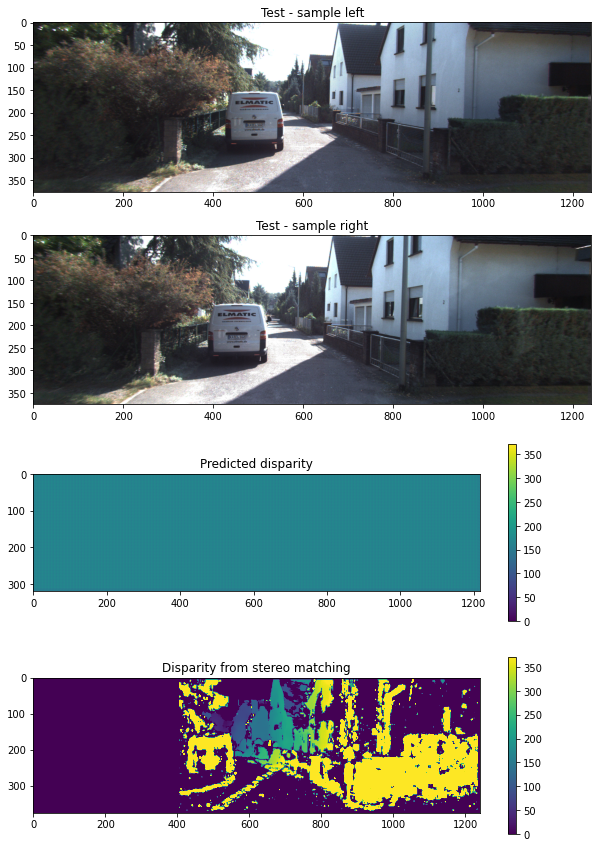

In [13]:
test_L, test_R = ToTensor()(left_img_val, right_img_val)
test_L, test_R = CenterCrop([320, 1216])(test_L, test_R)
test_L, test_R = NormalizeImg()(test_L, test_R)

if USE_GPU:
    test_L = test_L.cuda()
    test_R = test_R.cuda()

# calculate disparity from stereo matching
# the opencv algorithms use grayscale images as input
left_img_val_gray = cv.cvtColor(left_img_val, cv.COLOR_BGR2GRAY)
right_img_val_gray = cv.cvtColor(right_img_val, cv.COLOR_BGR2GRAY)
val_disp = stereo_construct.compute(left_img_val_gray, right_img_val_gray)

# here we simulate the situation where a monocular image is used for inference
DepthNet.eval()
_, val_sample_disp = DepthNet.forward(test_L[None], right_img=None)
fig = plt.figure(figsize=(10,15))
ax1 = fig.add_subplot(4,1,1)
plt.title('Test - sample left')
ax1.imshow(left_img_val)
ax2 = fig.add_subplot(4,1,2)
plt.title('Test - sample right')
ax2.imshow(right_img_val)
ax3 = fig.add_subplot(4,1,3)
plt.title('Predicted disparity')
im = ax3.imshow(val_sample_disp.cpu().detach().numpy()[0,0,:,:], vmin=0, vmax=0.3*np.shape(left_img_val)[1])
fig.colorbar(im, ax=ax3)
ax4 = fig.add_subplot(4,1,4)
plt.title('Disparity from stereo matching')
im=ax4.imshow(val_disp, vmin=0, vmax=0.3*np.shape(left_img_val)[1])
fig.colorbar(im, ax=ax4)

## Conclusions
The approach proposed by Godard et al. [5] is a reasonable approach in theory based on their paper. The paper outlines an approach to first extract features from an input image, and then decode and produce disparity estimation based on the encoded features. The loss function used for training contains three different parts which take care of both consistency at the image level as well as consistency at the disparity level. In their paper, they show some very good results.

However, the training results outlined above show that training in this notebook was not successful. The inference results from the neural network are just outputs with repeated values. They are no where close to the disparity calculated based on window-based matching. Some of the following events may have caused this problem:
- The network, especially the loss function, was not constructed correctly
- The dataset used here is a lot smaller than the dataset used by the authors. This could mean that the model's understanding to the dataset may not be as comprehensive as the model trained by the authors
- Given the validation error is a lot higher than the training error, the networt is most likely overfitting. Training it with lower number of epochs or simplifying the model may help. Note that both validation error and training error record error over the whole dataset or epoch. Since both training and validation set contain almost the same number of images, the errors can be compared directly.
- Also it may be a good idea to revisit the design of the network (e.g kernel size, number of layers, weights, activation functions, etc.). The model proposed by the authors uses images of the size 512x256 as inputs but here images with size 1216x320, which is very close to the original size of KITTI images, are sent into the model. Changing the network design may extract and analyze more useful features.

Overall, even though the paper by Godard et al. describes a theoretically sound approach for self-supervised monocular depth estimation and they provide very reasonable results. The actual implementation here failed to achieve the goal. Revisting the design and implementation of this model may help resolve some problems. If self-supervised monocular depth estimation algorithms can produce accurate disparity/depth prediction in practice, especially if they can be simplied and run on embedded system in real-time, they would be extremely beneficial in the fields of autonomous driving and robotics.

## References
[1] D. Eigen, C. Puhrsch, and R. Fergus, "Depth map prediction from a single image using a multiscale deep network," in Proceedings of the 27th International Conference on Neural Information
Processing Systems - Volume 2, NIPS’14, (Cambridge, MA, USA), p. 2366-2374, MIT Press,
2014.

[2] Bo Li, Chunhua Shen, Yuchao Dai, A. van den Hengel, and Mingyi He, "Depth and surface normal estimation from monocular images using regression on deep features and hierarchical CRFs,"
in 2015 IEEE Conference on Computer Vision and Pattern Recognition (CVPR), pp. 1119-1127,
2015.

[3] H. Jung, Y. Kim, D. Min, C. Oh, and K. Sohn, "Depth prediction from a single image with
conditional adversarial networks," in 2017 IEEE International Conference on Image Processing
(ICIP), pp. 1717-1721, 2017.

[4] T. Zhou, M. Brown, N. Snavely, and D. G. Lowe, "Unsupervised learning of depth and egomotion from video," in 2017 IEEE Conference on Computer Vision and Pattern Recognition
(CVPR), pp. 6612-6619, 2017.

[5]  C. Godard, O. M. Aodha, and G. J. Brostow, "Unsupervised monocular depth estimation with
left-right consistency," in 2017 IEEE Conference on Computer Vision and Pattern Recognition
(CVPR), pp. 6602-6611, 2017.